In [88]:
%matplotlib inline

# %matplotlib qt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os, sys, pathlib, shlex, subprocess
import xbout
import scipy
import xhermes
from xhermes import *


sys.path.append(r"/users/jpm590/2dspace/post-processing/sdtools/")


from hermes3.utils import *


from hermes3.fluxes import *
from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.selectors import *

%load_ext autoreload
%autoreload 2
print("Done")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Done


In [89]:
db = CaseDB(
    case_dir = r"/users/jpm590/scratch/",
    grid_dir = r"/users/jpm590/2dspace/hermes-3/build-mc-master"
)

toload = [
    dict(name="MAST-U", id="251105-pump-0.95", unnormalise_geom = True, use_xhermes = True, squash = True)
]
cs = {}
for case in toload:
    cs[case["name"]] = db.load_case_2D(case["id"], use_squash = case["squash"], verbose = True)
    cs[case["name"]].extract_2d_tokamak_geometry()
    
m = cs["MAST-U"].ds

- Reading case 251105-pump-0.95
-----------------------
- Looking for squash file
- Squash file found. squash date 11/10/2025, 13:18:14, dmp file date 11/08/2025, 08:04:01

Unnormalising with xHermes


### Nd evolution

number of frames (total number of timestep) = 100
Using time = 0.0, frame_idx = 0
Nd vs Spar  |  t = 0.000000e+00 s
Using time = 0.0, frame_idx = 0
Nd vs Spar  |  t = 0.000000e+00 s
Using time = 0.0, frame_idx = 0
Nd vs Spar  |  t = 0.000000e+00 s
Using time = 0.0, frame_idx = 0
Nd vs Spar  |  t = 0.000000e+00 s
Using time = 9.999130057868516e-06, frame_idx = 1
Nd vs Spar  |  t = 9.999130e-06 s
Using time = 1.9998260115737032e-05, frame_idx = 2
Nd vs Spar  |  t = 1.999826e-05 s
Using time = 2.9997390173605543e-05, frame_idx = 3
Nd vs Spar  |  t = 2.999739e-05 s
Using time = 3.9996520231474064e-05, frame_idx = 4
Nd vs Spar  |  t = 3.999652e-05 s
Using time = 4.9995650289342575e-05, frame_idx = 5
Nd vs Spar  |  t = 4.999565e-05 s
Using time = 5.9994780347211086e-05, frame_idx = 6
Nd vs Spar  |  t = 5.999478e-05 s
Using time = 6.99939104050796e-05, frame_idx = 7
Nd vs Spar  |  t = 6.999391e-05 s
Using time = 7.999304046294813e-05, frame_idx = 8
Nd vs Spar  |  t = 7.999304e-05 s
Using time

MovieWriter ffmpeg unavailable; using Pillow instead.


Nd vs Spar  |  t = 9.899139e-04 s
Using time = 0.0, frame_idx = 0
Nd vs Spar  |  t = 0.000000e+00 s
Using time = 0.0, frame_idx = 0
Nd vs Spar  |  t = 0.000000e+00 s
Using time = 9.999130057868516e-06, frame_idx = 1
Nd vs Spar  |  t = 9.999130e-06 s
Using time = 1.9998260115737032e-05, frame_idx = 2
Nd vs Spar  |  t = 1.999826e-05 s
Using time = 2.9997390173605543e-05, frame_idx = 3
Nd vs Spar  |  t = 2.999739e-05 s
Using time = 3.9996520231474064e-05, frame_idx = 4
Nd vs Spar  |  t = 3.999652e-05 s
Using time = 4.9995650289342575e-05, frame_idx = 5
Nd vs Spar  |  t = 4.999565e-05 s
Using time = 5.9994780347211086e-05, frame_idx = 6
Nd vs Spar  |  t = 5.999478e-05 s
Using time = 6.99939104050796e-05, frame_idx = 7
Nd vs Spar  |  t = 6.999391e-05 s
Using time = 7.999304046294813e-05, frame_idx = 8
Nd vs Spar  |  t = 7.999304e-05 s
Using time = 8.999217052081664e-05, frame_idx = 9
Nd vs Spar  |  t = 8.999217e-05 s
Using time = 9.999130057868515e-05, frame_idx = 10
Nd vs Spar  |  t = 9.99

ValueError: unknown file extension: .mp4

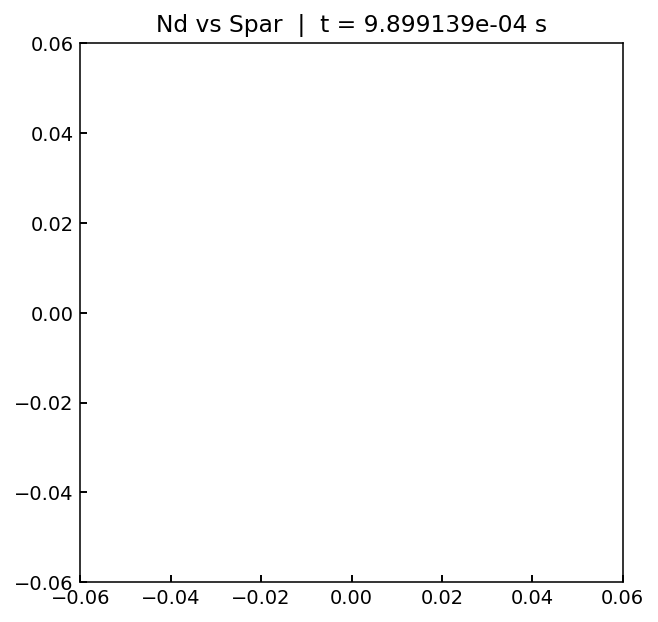

In [ ]:
# Get coordinate
ds_all = cs["MAST-U"].ds
t_vals = ds_all.t.values
n_frames =  100# len(t_vals)
print(f"number of frames (total number of timestep) = {n_frames}")
fig, ax = plt.subplots(figsize = (5,5))

line, = ax.plot([], [], lw=2)

def update(frame_idx):
    
    t_val = float(t_vals[frame_idx])
    print(f"Using time = {t_val}, frame_idx = {frame_idx}")
    
    ds_i = ds_all.sel(t=t_val)
    
    df_fieldline = get_1d_poloidal_data(
        ds_i, 
        params = ["Ne", "Nd+", "Nd"], 
        region = "outer_lower", 
        sepadd=1
    )
    
    x = df_fieldline["Spar"].values[::-1]
    y = df_fieldline["Nd"].values

    line.set_data(x,y)
    
    ax.set_title(f"Nd vs Spar  |  t = {t_val:.6e} s")
    print(f"Nd vs Spar  |  t = {t_val:.6e} s")
    return line,
    # display(df_fieldline.tail(5))
    # ax.clear()  
    # container = ax.plot(df_fieldline["Spar"].values[::-1], df_fieldline["Nd"])
    # artists.append(container)


ani = animation.FuncAnimation(fig, update, frames=n_frames, interval=200, blit=True)
HTML(ani.to_jshtml())
# ani
ani.save(filename="nd_vs_spar.mp4", writer="ffmpeg", fps=10)



In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

ds_all = cs["MAST-U"].ds
n_frames = int(n_times/100)

fig, ax = plt.subplots(figsize=(5,5))
line, = ax.plot([], [], lw=2)

def update(i):
    ds_i = ds_all.isel(t=i)
    df = get_1d_poloidal_data(ds_i,
                              params=["Ne", "Nd+", "Nd"],
                              region="outer_lower",
                              sepadd=1)

    x = df["Spar"].values[::-1]
    y = df["Nd"].values
    line.set_data(x, y)
    return line,

ani = FuncAnimation(fig, update, frames=n_frames, interval=300)
ani
ani.save("nd_vs_spar.gif", writer="ffmpeg", fps=20)



<IPython.core.display.Javascript object>

MovieWriter ffmpeg unavailable; using Pillow instead.
